Using device: cuda


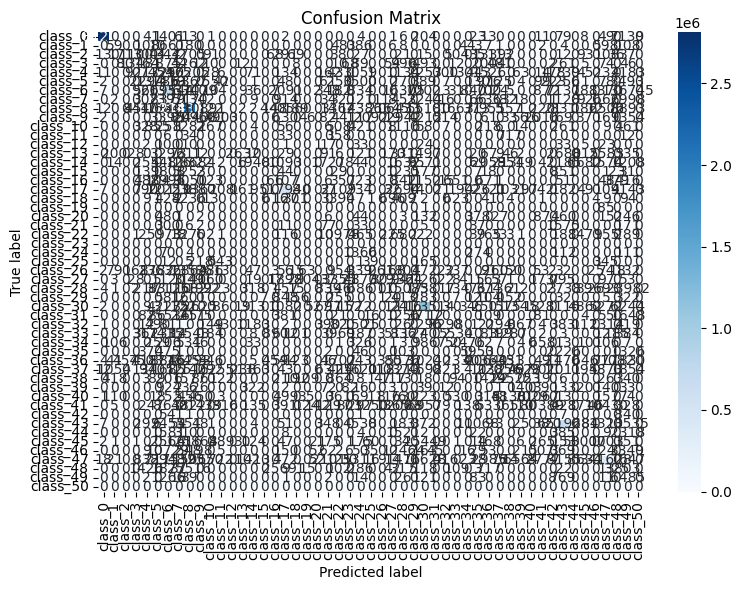

Average Loss       : 0.4910
Global Accuracy    : 0.8762
Macro Precision    : 0.4044
Macro Recall       : 0.3383
Macro F1-score     : 0.3270


/storage/courses/CropIdentification/DSWProject_CropIdentification/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
/storage/courses/CropIdentification/DSWProject_CropIdentification/venv/lib/python3.11/site-packages/sklearn/utils/multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)



[Final Test Evaluation]


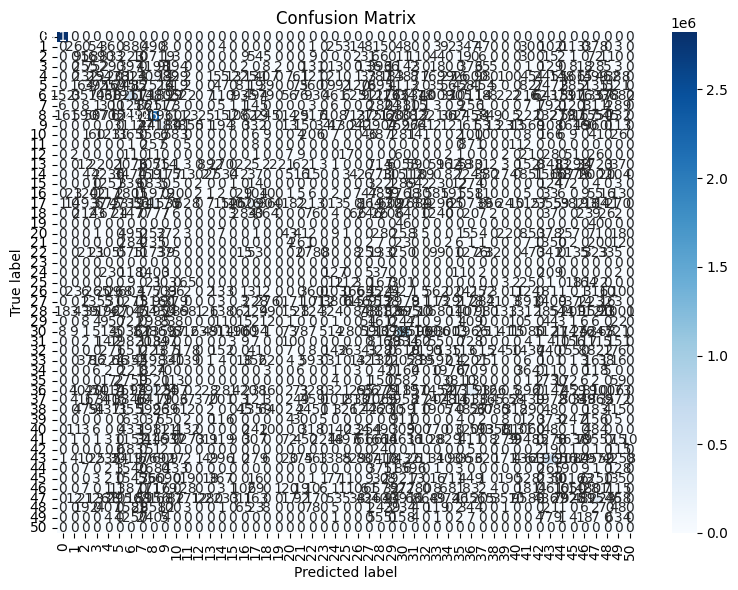

Average Loss       : 0.7358
Global Accuracy    : 0.8045
Macro Precision    : 0.3543
Macro Recall       : 0.2303
Macro F1-score     : 0.2524


In [8]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import h5py
import numpy as np
import joblib
from CNN.CNN_Model import CropTypeClassifier
from eval import evaluate
from sklearn.metrics import log_loss
# Set device to GPU if available for CNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ----------- CNN Evaluation ------------

# Load CNN test dataset from HDF5
with h5py.File('/storage/courses/CropIdentification/DSWProject_CropIdentification/data/dataset_test.h5', 'r') as f:
    X_test_cnn = torch.tensor(f['data'][:])
    Y_test_cnn = torch.tensor(f['labels'][:]).long()

test_dataset_cnn = TensorDataset(X_test_cnn, Y_test_cnn)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

def evaluate_cnn_model(model_path):
    """
    Load CNN model checkpoint (either a full checkpoint dict or just state_dict),
    evaluate on test set, print metrics and plot confusion matrix.
    """
    checkpoint = torch.load(model_path, map_location=device)

    # Se è dict con 'model_state_dict', caricalo, altrimenti usa direttamente il checkpoint come state_dict
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        kernel_size = checkpoint.get('kernel_size', 5)
        num_classes = checkpoint.get('num_classes', 51)
        state_dict = checkpoint['model_state_dict']
    else:
        kernel_size = 5  # default
        num_classes = 51  # default
        state_dict = checkpoint

    model = CropTypeClassifier(num_classes=num_classes, kernel_size=kernel_size).to(device)
    model.load_state_dict(state_dict)
    model.eval()

    criterion = nn.CrossEntropyLoss(ignore_index=255)

    y_true = []
    y_pred = []
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in test_loader_cnn:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item() * x.size(0)
            total_samples += x.size(0)

            preds = outputs.argmax(dim=1)
            y_true.append(y.view(-1).cpu())
            y_pred.append(preds.view(-1).cpu())

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    class_names = [f"class_{i}" for i in range(num_classes)]

    _, metrics = evaluate(
        y_true=y_true,
        y_pred=y_pred,
        num_classes=num_classes,
        total_loss=total_loss,
        data_length=total_samples,
        plot_cm=True,
        class_names=class_names
    )


#XGB evaluation


def map_labels(y, mapping):
    y_mapped = np.copy(y)
    for old_label, new_label in mapping.items():
        y_mapped[y == old_label] = new_label
    return y_mapped

def evaluate_xg_model(model_path, 
                      data_path='/storage/courses/CropIdentification/DSWProject_CropIdentification/data/test_pixelwise.npz',
                      scaler_path='/storage/courses/CropIdentification/DSWProject_CropIdentification/models/scaler.joblib'):

    # Load test data
    data = np.load(data_path)
    X_test_xg = data['X']
    y_test_xg = data['y']

    # Load XGBoost model and optional scaler
    xg_model = joblib.load(model_path)
    if scaler_path is not None:
        scaler = joblib.load(scaler_path)
        X_test_xg = scaler.transform(X_test_xg)

    # Get predictions and probabilities
    y_pred_xg_proba = xg_model.predict_proba(X_test_xg)
    y_pred_xg = np.argmax(y_pred_xg_proba, axis=1)

    # Get model classes and create mapping to indices
    classes_model = xg_model.classes_
    class_to_idx = {cls: idx for idx, cls in enumerate(classes_model)}

    # Remove samples with labels not seen during training
    mask = np.isin(y_test_xg, classes_model)
    if not np.all(mask):
        print(f"[WARNING] Removing {np.sum(~mask)} samples with unseen classes.")
    X_test_xg = X_test_xg[mask]
    y_test_xg = y_test_xg[mask]
    y_pred_xg_proba = y_pred_xg_proba[mask]
    y_pred_xg = y_pred_xg[mask]

    # Map test labels to index values
    y_test_mapped = np.array([class_to_idx[label] for label in y_test_xg])

    # Compute log-loss
    ll_test = log_loss(y_test_mapped, y_pred_xg_proba, labels=range(len(classes_model)))
    total_loss = ll_test * len(y_test_mapped)

    # Prepare class names and evaluate metrics with confusion matrix
    num_classes = len(classes_model)
    class_names = [str(cls) for cls in classes_model]

    print("\n[Final Test Evaluation]")
    cm_test, metrics_test = evaluate(
        y_true=y_test_mapped,
        y_pred=y_pred_xg,
        num_classes=num_classes,
        total_loss=total_loss,
        data_length=len(y_test_mapped),
        plot_cm=True,
        class_names=class_names,
    )




# ----------- Main evaluation -----------

# Specify your best CNN and XG model paths here
best_cnn_models = [
    '/storage/courses/CropIdentification/DSWProject_CropIdentification/models/best_model_cnn.pth'
]

best_xg_models = [
    '/storage/courses/CropIdentification/DSWProject_CropIdentification/models/xgb_best_model.joblib'
]

# Evaluate CNN models
for cnn_path in best_cnn_models:
    evaluate_cnn_model(cnn_path)

# Evaluate XG models
for xg_path in best_xg_models:
    evaluate_xg_model(xg_path)
